# Impute Values

In [1]:
import pandas as pd

instances = pd.read_csv('Instances.csv', delimiter='\t')

# get median of Environmental Audio Exposure (dBASPL)
medianAudio = instances['Environmental Audio Exposure (dBASPL)'].median()

# ge median of Blood Oxygen Saturation (%)
medianBlood = instances['Blood Oxygen Saturation (%)'].median()

print('Median of Environmental Audio Exposure (dBASPL):', medianAudio)
print('Median of Blood Oxygen Saturation (%):', medianBlood)

instances['Environmental Audio Exposure (dBASPL)'].fillna(medianAudio, inplace=True)
instances['Blood Oxygen Saturation (%)'].fillna(medianBlood, inplace=True)
instances['Walking Speed (km/hr)'].fillna(0.0, inplace=True)

# instances.to_csv('instances_imputed.csv', sep='\t', index=False)


Median of Environmental Audio Exposure (dBASPL): 69.73
Median of Blood Oxygen Saturation (%): 97.0


/var/folders/sf/20skkktd46x8gg00sslntnnc0000gn/T/ipykernel_16805/1521338310.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  instances['Environmental Audio Exposure (dBASPL)'].fillna(medianAudio, inplace=True)
/var/folders/sf/20skkktd46x8gg00sslntnnc0000gn/T/ipykernel_16805/1521338310.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje

Mean of HRV: 49.39074129297067


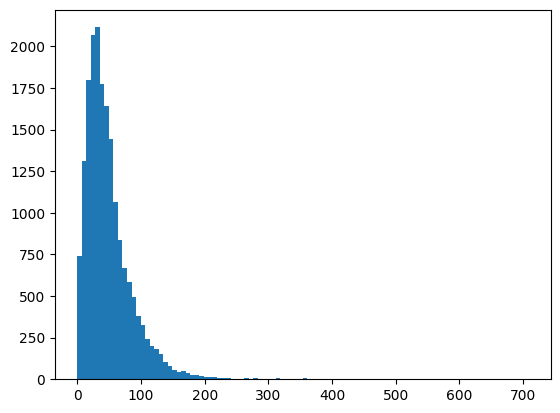

In [32]:
import numpy as np

import matplotlib.pyplot as plt
# Show histograms for each column
restingHeartRateDf = pd.read_csv("Raw Data/Resting Heart Rate 2.csv")

# mean of resting heart rate
meanRestingHeartRate = restingHeartRateDf['Resting Heart Rate (count/min)'].mean()

instances['RR Interval BPM Max'] = 60000 / instances['Min (count/min)'] 
instances['RR Interval BPM Min'] = 60000 / instances['Max (count/min)'] 
hrv = instances['RR Interval BPM Max'] - instances['RR Interval BPM Min']  
#histogram of HRV where HRV > 0
plt.hist(hrv[hrv > 0], bins=100)
print('Mean of HRV:', hrv[hrv > 0].mean())
lowHRVThresh, medHRVThresh, highHRVTrhesh = hrv.quantile([0.25, 0.5, 0.75])
print('25th percentile of HRV:', lowHRVThresh)
print('50th percentile of HRV:', medHRVThresh)
print('75th percentile of HRV:', highHRVTrhesh)

# print('Mean of HRV:', instances['Heart Rate Variability (ms)'].mean())

# instances['HRV'] = np.sqrt(((instances['Min (count/min)'] - instances['Avg (count/min)'])**2 + (instances['Max (count/min)'] - instances['Avg (count/min)'])**2) / 2)
# hrv = instances['HRV']
# # hrv = instances['Heart Rate Variability (ms)']
# print('Mean of HRV:', hrv.mean())
# print('Median of HRV:', hrv.median())
# print('Standard deviation of HRV:', hrv.std())
# print('Maximum of HRV:', hrv.max())

# plt.hist(hrv[hrv > 0], bins=100)

# print the number of instances where HRV is greater than 0
#print('Number of instances where HRV is greater than 0:', hrv[hrv > 0].count())


# in 1 minuut:
# Eerste meting
# 30 ms
# 25 ms
# 25 ms
# 27 ms
# 29 ms
# average: 27.2 ms -> 80 bpm

# Tweede meting
# 32 ms
# 30 ms
# 25 ms
# 30 ms
# 31 ms
# average: 30.4 ms -> 100 bpm

# Derde meting
#....


# HRV: verschil tusssen alle ms
# HRV Proxy: met bpm min-max



# cardiovascular stress level
# heart rate hoog + lage HRV -> stress
# heart rate gemiddeld -> normaal stress
# heart rate laag -> niet gestrest

# HEART RATE HOOG IS 75TH PERCENTILE
# HEART RATE GEMIDDELD IS 50TH PERCENTILE
# HEART RATE LAAG IS 25TH PERCENTILE
# code to get quantiles:
lowHeartThresh, medHeartThresh, highHeartTrhesh = instances['Avg (count/min)'].quantile([0.25, 0.5, 0.75])



